In [1]:
from pathlib import Path
import json
import pandas as pd

from corr_analysis_functions import (
    get_models_set,
    model_task_count,
    filter_common_models,
    kendall_w,
    normalize_scores,
    rank_with_margin,
)
from corr_plotting import plot_radar_chart, plot_ranks

In [2]:
folder = Path("")
dataset_file = folder / "tasks_results.json"

with open(dataset_file, "r") as file:
    task_results = json.load(file)

# convert all tasks and model names to lower
task_results = {
    key.lower(): {key_in.lower(): value_in for key_in, value_in in value.items()}
    for key, value in task_results.items()
}

In [3]:
for task, scores in task_results.items():
    task_results[task] = normalize_scores(scores)

In [4]:
model_dict = get_models_set(task_results)
model_count = model_task_count(task_results)
model_list = sorted(list(model_count.keys()))
task_results_common = filter_common_models(task_results)

In [5]:
# if False:
#     with open("model_count.json", "w") as file:
#         json.dump(model_count, file, indent=4)
#     with open("model_list.txt", "w") as file:
#         file.write("\n".join(model_list))

In [6]:
task_results_df = pd.DataFrame(task_results_common)
# task_results_df.loc["best"] = 1.0
# task_results_df.loc["worst"] = 0.0
# task_results_ranked = task_results_df.rank(ascending=False, method='min')
task_results_ranked = rank_with_margin(task_results_df)
# task_spearman_corr = task_results_df.corr(method='spearman')

In [7]:
mean_ranks = task_results_ranked.mean(axis=1)
std_ranks = task_results_ranked.std(axis=1)
rank_stats = pd.DataFrame({"Mean Rank": mean_ranks, "Std Dev": std_ranks})
rank_stats

,Mean Rank,Std Dev
gpt-o1,1.4,0.547723
gpt-4o,2.4,0.894427
claude-3.5 sonnet,1.8,0.836660


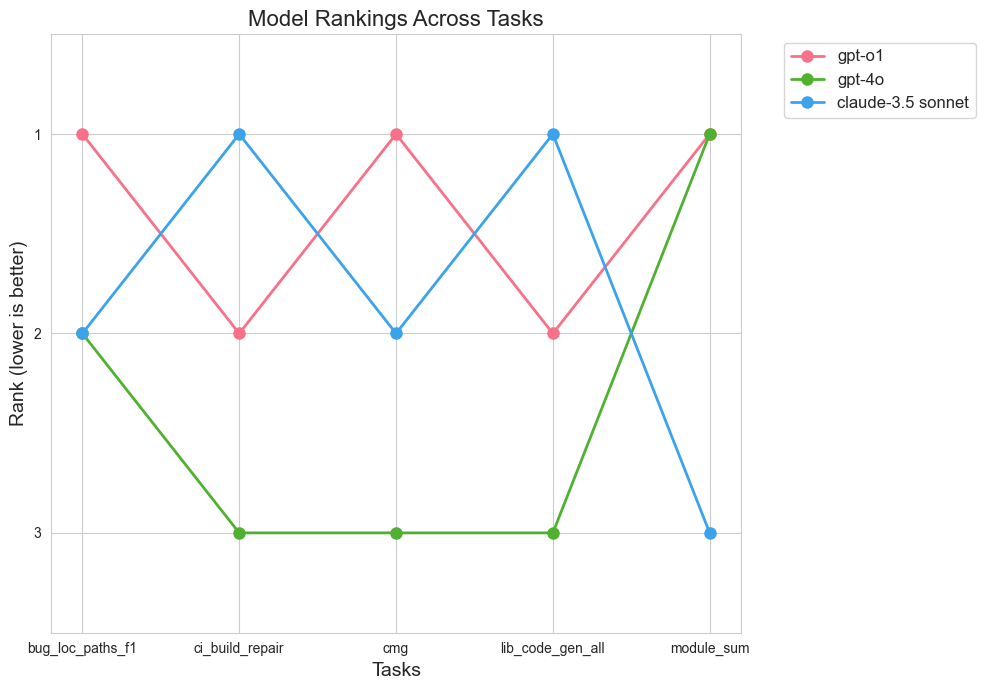

In [8]:
plot_ranks(task_results_ranked)

In [9]:
# plot_corr_matrix(task_results_df)

In [10]:
kendall_w(task_results_df)

{'W': 0.010354241034353211,
 'chi2': 0.10354241034353212,
 'p_value': 0.9495460932271055}

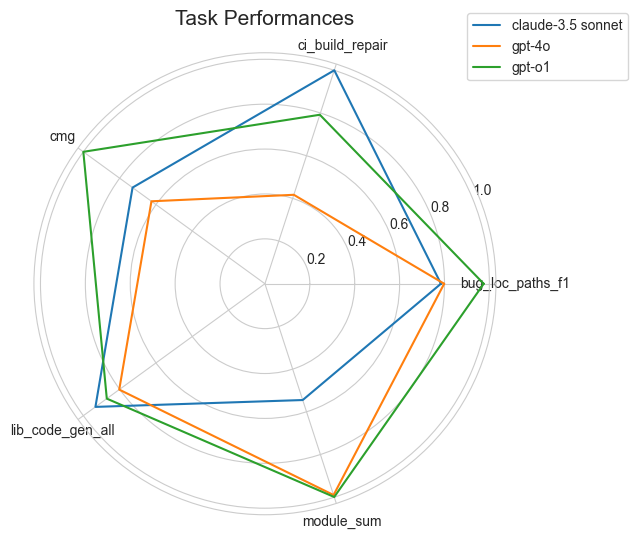

In [11]:
plot_radar_chart(task_results_df)